In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
from autogluon.tabular import TabularDataset, TabularPredictor

from helpers import data

c:\Users\tetha\miniforge3\envs\autogluon_3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def make_dataset(dataset):

    dataset = TabularDataset(dataset)
    dataset["isSignal"] = dataset["isSignal"].fillna(value=0)
    return dataset

In [4]:
label = "isSignal"

features = [
    "tfRedChiSqB0", 
    "deltaE", 
    "invM_K_pi_shifted",
    # "K_p_kaonID", 
    "K_p_dr", 
    "K_p_dz", 
    "pi_m_dr", 
    "pi_m_dz", 
    "mu_p_dr", 
    "mu_p_dz", 
    # "mu_p_muonID", 
    "mu_m_dr", 
    "mu_m_dz", 
    # "mu_m_muonID",
]

q_sq_veto = "resonances"

In [5]:
signal = {
    split : data.open_agg_signal_file("det", split, q_sq_veto)
    for split in ["train", "val"]    
}

signal_sm = {
    split : signal[split][signal[split]["dc9"] == 0] 
    for split in ["train", "val"]
}

bkg_mbc_sb = {
    split : pandas.concat(
        [
            data.load_generic_split("charge", "mbc_sb", "bkg", split),
            data.load_generic_split("mix", "mbc_sb", "bkg", split)
        ]
    ) for split in ["train", "val"]
}

dsets_mbc_sb = {
    split : make_dataset(
        pandas.concat([
            bkg_mbc_sb[split],
            signal_sm[split].iloc[:len(bkg_mbc_sb[split])]
        ])
    ) for split in ["train", "val"]
}

dset_sr_val = make_dataset(
    pandas.concat(
        [
            data.load_generic_split("charge", "sr", "bkg", "val"),
            data.load_generic_split("mix", "sr", "bkg", "val"),
            data.load_generic_split("mix", "sr", "sig", "val"),
        ]
    )
)

In [ ]:
df_train = dsets_mbc_sb["train"]
df_val = dset_sr_val

sig_train = df_train[df_train[label]==1]
sig_val = df_val[df_val[label]==1]
bkg_train = df_train[df_train[label]==0]
bkg_val = df_val[df_val[label]==0]


ranges = {
    "isSignal" : (-1, 2),
    "tfRedChiSqB0" : (-2, 20), 
    "deltaE" : (-0.1, 0.1),
    "invM_K_pi_shifted" : (-0.25, 0.25),
    "K_p_kaonID" : (0.999999999, 1),
    "K_p_dr" : (0, 0.03),
    "K_p_dz" : (-0.25, 0.25),
    "pi_m_dr" : (0, 0.05),
    "pi_m_dz" : (-0.25, 0.25),
    "mu_p_dr" : (0, 0.03),
    "mu_p_dz" : (-0.25, 0.25),
    "mu_p_muonID" : (0.9999, 1),
    "mu_m_dr" : (0, 0.03),
    "mu_m_dz" : (-0.25, 0.25),
    "mu_m_muonID" : (0.9999, 1)
}

for col in features:

    try:
        plt.hist(sig_train[col], bins=50, range=ranges[col], density=True, histtype="step")
        plt.hist(sig_val[col], bins=50, range=ranges[col], density=True, histtype="step")
        plt.hist(bkg_train[col], bins=50, range=ranges[col], density=True, histtype="step")
        plt.hist(bkg_val[col], bins=50, range=ranges[col], density=True, histtype="step")
        plt.xlabel(col)
        plt.show()
        
    except ValueError:
        print("error ", col)

In [6]:
predictor = (
    TabularPredictor(label=label)
    .fit(
        dsets_mbc_sb["train"][features+[label]], 
        time_limit=1200, 
        presets="best"
    )
)

No path specified. Models will be saved in: "AutogluonModels\ag-20250918_191312"
Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       46.86 GB / 63.10 GB (74.3%)
Disk Space Avail:   414.74 GB / 1862.07 GB (22.3%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identif

(_ray_fit pid=162104) [1000]	valid_set's binary_error: 0.124929
(_ray_fit pid=162104) [2000]	valid_set's binary_error: 0.124055 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=160204) [3000]	valid_set's binary_error: 0.122927 [repeated 6x across cluster]


(_dystack pid=158132) 	0.8768	 = Validation score   (accuracy)
(_dystack pid=158132) 	25.15s	 = Training   runtime
(_dystack pid=158132) 	10.32s	 = Validation runtime
(_dystack pid=158132) Fitting model: LightGBM_BAG_L1 ... Training model for up to 165.17s of the 263.82s of remaining time.
(_dystack pid=158132) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=2, gpus=0, memory=0.37%)


(_ray_fit pid=159968) [1000]	valid_set's binary_error: 0.121968 [repeated 2x across cluster]
(_ray_fit pid=160212) [3000]	valid_set's binary_error: 0.123012 [repeated 5x across cluster]


(_dystack pid=158132) 	0.877	 = Validation score   (accuracy)
(_dystack pid=158132) 	17.36s	 = Training   runtime
(_dystack pid=158132) 	4.04s	 = Validation runtime
(_dystack pid=158132) Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 144.48s of the 243.13s of remaining time.
(_dystack pid=158132) 	0.8743	 = Validation score   (accuracy)
(_dystack pid=158132) 	27.61s	 = Training   runtime
(_dystack pid=158132) 	5.96s	 = Validation runtime
(_dystack pid=158132) Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 110.48s of the 209.12s of remaining time.
(_dystack pid=158132) 	0.8743	 = Validation score   (accuracy)
(_dystack pid=158132) 	40.17s	 = Training   runtime
(_dystack pid=158132) 	6.54s	 = Validation runtime
(_dystack pid=158132) Fitting model: CatBoost_BAG_L1 ... Training model for up to 63.34s of the 161.98s of remaining time.
(_dystack pid=158132) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 worke

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 144f39adcfa902473b903fcbe2f7683ad8292d5701000000 Worker ID: 89b6f0ef62a06c2ca4bb8e05156304f3f86342486ef51af13d267ff8 Node ID: eabe482233b62b3c79f8ebaf2922d0777c85413a5a1d05fa62bd2244 Worker IP address: 127.0.0.1 Worker port: 49266 Worker PID: 158132 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 10054. An existing connection was forcibly closed by the remote host. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


(_dystack pid=163492) Running DyStack sub-fit ...
(_dystack pid=163492) Beginning AutoGluon training ... Time limit = 296s
(_dystack pid=163492) AutoGluon will save models to "c:\Users\tetha\Desktop\btokstmumu-ml\AutogluonModels\ag-20250918_191312\ds_sub_fit\sub_fit_ho"
(_dystack pid=163492) Train Data Rows:    283681
(_dystack pid=163492) Train Data Columns: 11
(_dystack pid=163492) Label Column:       isSignal
(_dystack pid=163492) Problem Type:       binary
(_dystack pid=163492) Preprocessing data ...
(_dystack pid=163492) Selected class <--> label mapping:  class 1 = 1, class 0 = 0
(_dystack pid=163492) Using Feature Generators to preprocess the data ...
(_dystack pid=163492) Fitting AutoMLPipelineFeatureGenerator...
(_dystack pid=163492) 	Available Memory:                    47318.43 MB
(_dystack pid=163492) 	Train Data (Original)  Memory Usage: 23.81 MB (0.1% of available memory)
(_dystack pid=163492) 	Inferring data type of each feature based on column values. Set feature_metada

(_ray_fit pid=163184) [1000]	valid_set's binary_error: 0.124929
(_ray_fit pid=163184) [2000]	valid_set's binary_error: 0.123914 [repeated 8x across cluster]
(_ray_fit pid=160856) [3000]	valid_set's binary_error: 0.122927 [repeated 6x across cluster]


(_dystack pid=163492) 	0.8768	 = Validation score   (accuracy)
(_dystack pid=163492) 	25.07s	 = Training   runtime
(_dystack pid=163492) 	10.35s	 = Validation runtime
(_dystack pid=163492) Fitting model: LightGBM_BAG_L1 ... Training model for up to 165.57s of the 264.22s of remaining time.
(_dystack pid=163492) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=2, gpus=0, memory=0.38%)


(_ray_fit pid=163176) [1000]	valid_set's binary_error: 0.121968 [repeated 2x across cluster]
(_ray_fit pid=163192) [3000]	valid_set's binary_error: 0.123012 [repeated 5x across cluster]


(_dystack pid=163492) 	0.877	 = Validation score   (accuracy)
(_dystack pid=163492) 	17.49s	 = Training   runtime
(_dystack pid=163492) 	4.0s	 = Validation runtime
(_dystack pid=163492) Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 144.78s of the 243.43s of remaining time.
(_dystack pid=163492) 	0.8743	 = Validation score   (accuracy)
(_dystack pid=163492) 	27.48s	 = Training   runtime
(_dystack pid=163492) 	5.99s	 = Validation runtime
(_dystack pid=163492) Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 110.81s of the 209.46s of remaining time.
(_dystack pid=163492) 	0.8743	 = Validation score   (accuracy)
(_dystack pid=163492) 	40.34s	 = Training   runtime
(_dystack pid=163492) 	6.53s	 = Validation runtime
(_dystack pid=163492) Fitting model: CatBoost_BAG_L1 ... Training model for up to 63.47s of the 162.12s of remaining time.
(_dystack pid=163492) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 worker

In [ ]:
predictor = TabularPredictor.load("AutogluonModels/ag-20250918_19131")

$M_{bc}$ sideband validation

In [7]:
preds_val_mbc_sb = predictor.predict_proba(dsets_mbc_sb["val"].drop(columns=[label])[features])
preds_val_mbc_sb_sig = preds_val_mbc_sb[dsets_mbc_sb["val"][label] == 1][1]
preds_val_mbc_sb_bkg = preds_val_mbc_sb[dsets_mbc_sb["val"][label] == 0][1]

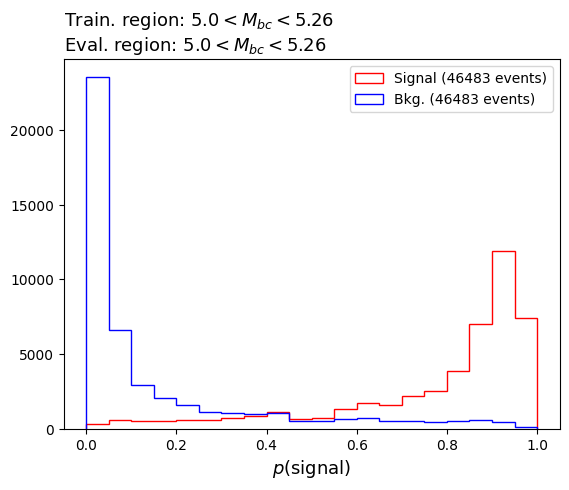

In [8]:
plt.hist(preds_val_mbc_sb_sig, label=f"Signal ({len(preds_val_mbc_sb_sig)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_val_mbc_sb_bkg, label=f"Bkg. ({len(preds_val_mbc_sb_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $5.0 < M_{bc} < 5.26$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.show()
# plt.savefig("bkg_sup_sb_sr", bbox_inches="tight")
# plt.close()

Signal region validation

In [9]:
preds_val_sr = predictor.predict_proba(dset_sr_val.drop(columns=[label])[features])
preds_val_sr_sig = preds_val_sr[dset_sr_val[label] == 1][1]
preds_val_sr_bkg = preds_val_sr[dset_sr_val[label] == 0][1]

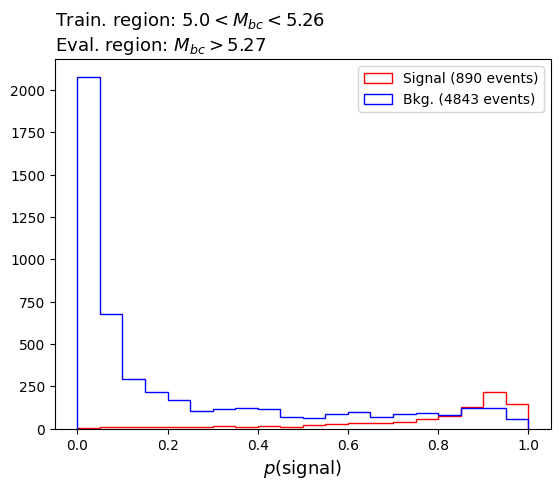

In [10]:
plt.hist(preds_val_sr_sig, label=f"Signal ({len(preds_val_sr_sig)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_val_sr_bkg, label=f"Bkg. ({len(preds_val_sr_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $M_{bc} > 5.27$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.show()
# plt.savefig("bkg_sup_sr", bbox_inches="tight")
# plt.close()

Metric for cut

best metric 19.28411731813792
best threshold:  0.6124031007751938
best ratio (bkg:sig):  0.963013698630137
best bkg. frac.:  0.49057920446615494


C:\Users\tetha\AppData\Local\Temp\ipykernel_15504\2387419782.py:5: RuntimeWarning: invalid value encountered in divide
  ratio_bkg_to_sig = counts_bkg / counts_sig
C:\Users\tetha\AppData\Local\Temp\ipykernel_15504\2387419782.py:6: RuntimeWarning: invalid value encountered in divide
  bkg_frac = counts_bkg / (counts_bkg + counts_sig)
C:\Users\tetha\AppData\Local\Temp\ipykernel_15504\2387419782.py:7: RuntimeWarning: invalid value encountered in divide
  metric = counts_sig/numpy.sqrt(counts_sig+counts_bkg)


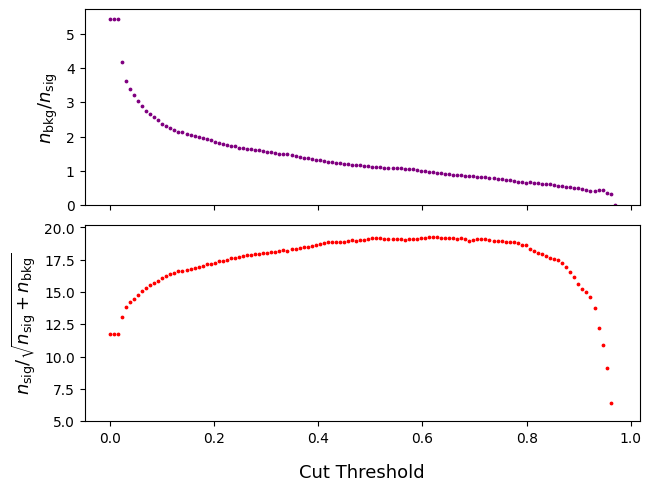

In [11]:
p_thresholds = numpy.linspace(0, 1, 130)

counts_sig = numpy.array([len(preds_val_sr_sig[preds_val_sr_sig > thresh]) for thresh in p_thresholds])
counts_bkg = numpy.array([len(preds_val_sr_bkg[preds_val_sr_bkg > thresh]) for thresh in p_thresholds])
ratio_bkg_to_sig = counts_bkg / counts_sig
bkg_frac = counts_bkg / (counts_bkg + counts_sig)
metric = counts_sig/numpy.sqrt(counts_sig+counts_bkg)

assert len(metric) == len(p_thresholds) == len(ratio_bkg_to_sig)

best_metric = numpy.nanmax(metric)
index_of_best_metric = numpy.nanargmax(metric)
best_threshold = p_thresholds[index_of_best_metric]
best_ratio_bkg_to_sig = ratio_bkg_to_sig[index_of_best_metric]
best_bkg_frac = bkg_frac[index_of_best_metric]
print("best metric", best_metric)
print("best threshold: ", best_threshold)
print("best ratio (bkg:sig): ", best_ratio_bkg_to_sig)
print("best bkg. frac.: ", best_bkg_frac)

fig, axs = plt.subplots(2,  1, sharex=True, layout="compressed")

axs.flat[0].scatter(p_thresholds, ratio_bkg_to_sig, color="purple", s=3)
axs.flat[0].set_ylabel(r"$n_\text{bkg} / n_\text{sig}$", fontsize=13)
axs.flat[0].set_ylim(bottom=0)

axs.flat[1].set_xlabel("Cut Threshold", fontsize=13, labelpad=13)
axs.flat[1].set_ylabel(r"$n_\text{sig} / \sqrt{n_\text{sig} + n_\text{bkg}}$", fontsize=13)
axs.flat[1].scatter(p_thresholds, metric, color="red", s=3)
axs.flat[1].set_ylim(bottom=5)

plt.show()
# plt.savefig("bkg_sup_ratio.png", bbox_inches="tight")
# plt.close()

In [12]:
dset_sr_val_charge = data.load_generic_split("charge", "sr", "bkg", "val")
dset_sr_val_mix = data.load_generic_split("mix", "sr", "bkg", "val")

preds_sr_val_charge = predictor.predict_proba(dset_sr_val_charge.drop(columns=[label])[features])
preds_sr_val_charge_bkg = preds_sr_val_charge[dset_sr_val_charge[label]==0][1]

preds_sr_val_mix = predictor.predict_proba(dset_sr_val_mix.drop(columns=[label])[features])
preds_sr_val_mix_bkg = preds_sr_val_mix[dset_sr_val_mix[label]==0][1]

print("Before bkg. suppression: ", len(preds_sr_val_charge_bkg) + len(preds_sr_val_mix_bkg))

num_pass_charge = len(preds_sr_val_charge_bkg[preds_sr_val_charge_bkg > best_threshold])
num_pass_mix = len(preds_sr_val_mix_bkg[preds_sr_val_mix_bkg > best_threshold])
print("Pass bkg. suppression: ", num_pass_charge + num_pass_mix)

charge_frac_after_bkg_sup = num_pass_charge / (num_pass_charge + num_pass_mix)
print("Charge fraction after bkg. suppression: ", charge_frac_after_bkg_sup)

Before bkg. suppression:  4601
Pass bkg. suppression:  666
Charge fraction after bkg. suppression:  0.33483483483483484
